In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, glossQ, dlossQ, _ = sess.run([model.d_loss, model.g_lossQ, model.d_lossQ, 
                                                 model.d_opt], #, model.d_optQ
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 gloss:1.3740 dloss:2.0199 glossQ:1.0032 dlossQ:1.3695 exploreP:0.9984
Episode:1 meanR:23.0000 R:30.0000 rate:0.0600 gloss:1.3718 dloss:2.0111 glossQ:1.0053 dlossQ:1.3171 exploreP:0.9955
Episode:2 meanR:20.6667 R:16.0000 rate:0.0320 gloss:1.3680 dloss:1.9960 glossQ:1.0087 dlossQ:1.2404 exploreP:0.9939
Episode:3 meanR:20.2500 R:19.0000 rate:0.0380 gloss:1.3673 dloss:1.9913 glossQ:1.0119 dlossQ:1.2139 exploreP:0.9920
Episode:4 meanR:20.2000 R:20.0000 rate:0.0400 gloss:1.3625 dloss:1.9778 glossQ:1.0099 dlossQ:1.2169 exploreP:0.9901
Episode:5 meanR:20.0000 R:19.0000 rate:0.0380 gloss:1.3614 dloss:1.9685 glossQ:1.0114 dlossQ:1.1901 exploreP:0.9882
Episode:6 meanR:20.8571 R:26.0000 rate:0.0520 gloss:1.3571 dloss:1.9517 glossQ:1.0128 dlossQ:1.1232 exploreP:0.9857
Episode:7 meanR:19.8750 R:13.0000 rate:0.0260 gloss:1.3587 dloss:1.9537 glossQ:1.0141 dlossQ:1.1523 exploreP:0.9844
Episode:8 meanR:23.5556 R:53.0000 rate:0.1060 gloss:1.3492 dloss:1.9205 

Episode:71 meanR:27.1667 R:15.0000 rate:0.0300 gloss:1.2221 dloss:1.4964 glossQ:1.0974 dlossQ:1.2476 exploreP:0.8241
Episode:72 meanR:27.0685 R:20.0000 rate:0.0400 gloss:1.2189 dloss:1.4891 glossQ:1.0971 dlossQ:1.2399 exploreP:0.8225
Episode:73 meanR:27.0135 R:23.0000 rate:0.0460 gloss:1.2269 dloss:1.4988 glossQ:1.0989 dlossQ:1.2625 exploreP:0.8206
Episode:74 meanR:26.8400 R:14.0000 rate:0.0280 gloss:1.2213 dloss:1.4873 glossQ:1.0929 dlossQ:1.2430 exploreP:0.8195
Episode:75 meanR:26.8816 R:30.0000 rate:0.0600 gloss:1.2142 dloss:1.4761 glossQ:1.1028 dlossQ:1.2579 exploreP:0.8171
Episode:76 meanR:26.8312 R:23.0000 rate:0.0460 gloss:1.2028 dloss:1.4595 glossQ:1.1067 dlossQ:1.2691 exploreP:0.8152
Episode:77 meanR:26.8974 R:32.0000 rate:0.0640 gloss:1.1945 dloss:1.4453 glossQ:1.1253 dlossQ:1.3074 exploreP:0.8126
Episode:78 meanR:26.7975 R:19.0000 rate:0.0380 gloss:1.2087 dloss:1.4609 glossQ:1.0985 dlossQ:1.2439 exploreP:0.8111
Episode:79 meanR:26.9000 R:35.0000 rate:0.0700 gloss:1.2136 dlos

Episode:141 meanR:31.8400 R:23.0000 rate:0.0460 gloss:1.1329 dloss:1.3062 glossQ:1.1438 dlossQ:1.1317 exploreP:0.6599
Episode:142 meanR:31.8900 R:27.0000 rate:0.0540 gloss:1.1583 dloss:1.3325 glossQ:1.1196 dlossQ:1.1078 exploreP:0.6581
Episode:143 meanR:32.0600 R:40.0000 rate:0.0800 gloss:1.1349 dloss:1.3096 glossQ:1.1344 dlossQ:1.1243 exploreP:0.6556
Episode:144 meanR:31.8600 R:30.0000 rate:0.0600 gloss:1.1358 dloss:1.3085 glossQ:1.1356 dlossQ:1.1243 exploreP:0.6536
Episode:145 meanR:32.4900 R:76.0000 rate:0.1520 gloss:1.1259 dloss:1.2978 glossQ:1.1390 dlossQ:1.1301 exploreP:0.6487
Episode:146 meanR:32.5200 R:19.0000 rate:0.0380 gloss:1.1252 dloss:1.2962 glossQ:1.1334 dlossQ:1.1226 exploreP:0.6475
Episode:147 meanR:32.5900 R:26.0000 rate:0.0520 gloss:1.1290 dloss:1.3010 glossQ:1.1400 dlossQ:1.1279 exploreP:0.6459
Episode:148 meanR:32.6000 R:31.0000 rate:0.0620 gloss:1.1261 dloss:1.2980 glossQ:1.1466 dlossQ:1.1363 exploreP:0.6439
Episode:149 meanR:32.7000 R:32.0000 rate:0.0640 gloss:1.

Episode:211 meanR:42.2600 R:21.0000 rate:0.0420 gloss:1.1504 dloss:1.3162 glossQ:1.1381 dlossQ:1.0855 exploreP:0.4771
Episode:212 meanR:42.4100 R:30.0000 rate:0.0600 gloss:1.1647 dloss:1.3343 glossQ:1.1395 dlossQ:1.0809 exploreP:0.4757
Episode:213 meanR:42.2200 R:29.0000 rate:0.0580 gloss:1.1393 dloss:1.3098 glossQ:1.1396 dlossQ:1.0814 exploreP:0.4743
Episode:214 meanR:43.5500 R:145.0000 rate:0.2900 gloss:1.1398 dloss:1.3059 glossQ:1.1380 dlossQ:1.0777 exploreP:0.4677
Episode:215 meanR:43.5900 R:28.0000 rate:0.0560 gloss:1.1452 dloss:1.3098 glossQ:1.1286 dlossQ:1.0553 exploreP:0.4664
Episode:216 meanR:43.9100 R:48.0000 rate:0.0960 gloss:1.1325 dloss:1.2972 glossQ:1.1470 dlossQ:1.0772 exploreP:0.4642
Episode:217 meanR:44.0700 R:53.0000 rate:0.1060 gloss:1.1479 dloss:1.3117 glossQ:1.1715 dlossQ:1.0948 exploreP:0.4618
Episode:218 meanR:44.5300 R:92.0000 rate:0.1840 gloss:1.1411 dloss:1.3071 glossQ:1.1399 dlossQ:1.0744 exploreP:0.4576
Episode:219 meanR:44.4700 R:24.0000 rate:0.0480 gloss:1

Episode:281 meanR:62.1700 R:222.0000 rate:0.4440 gloss:1.1420 dloss:1.2895 glossQ:1.1516 dlossQ:0.9868 exploreP:0.3041
Episode:282 meanR:62.1400 R:33.0000 rate:0.0660 gloss:1.1435 dloss:1.2923 glossQ:1.1506 dlossQ:0.9943 exploreP:0.3031
Episode:283 meanR:62.7300 R:89.0000 rate:0.1780 gloss:1.1576 dloss:1.3084 glossQ:1.1447 dlossQ:0.9818 exploreP:0.3005
Episode:284 meanR:62.6500 R:31.0000 rate:0.0620 gloss:1.1344 dloss:1.2876 glossQ:1.1541 dlossQ:0.9903 exploreP:0.2996
Episode:285 meanR:64.5600 R:224.0000 rate:0.4480 gloss:1.1415 dloss:1.2909 glossQ:1.1557 dlossQ:0.9878 exploreP:0.2932
Episode:286 meanR:64.7400 R:58.0000 rate:0.1160 gloss:1.1632 dloss:1.3145 glossQ:1.1571 dlossQ:0.9919 exploreP:0.2916
Episode:287 meanR:64.1500 R:23.0000 rate:0.0460 gloss:1.1292 dloss:1.2860 glossQ:1.1472 dlossQ:0.9957 exploreP:0.2909
Episode:288 meanR:64.0600 R:22.0000 rate:0.0440 gloss:1.1872 dloss:1.3348 glossQ:1.1656 dlossQ:0.9741 exploreP:0.2903
Episode:289 meanR:64.2200 R:44.0000 rate:0.0880 gloss:

Episode:351 meanR:65.4500 R:49.0000 rate:0.0980 gloss:1.1788 dloss:1.3312 glossQ:1.1430 dlossQ:0.9499 exploreP:0.1984
Episode:352 meanR:65.3800 R:50.0000 rate:0.1000 gloss:1.1812 dloss:1.3336 glossQ:1.2149 dlossQ:1.0192 exploreP:0.1975
Episode:353 meanR:65.4300 R:70.0000 rate:0.1400 gloss:1.1864 dloss:1.3418 glossQ:1.1509 dlossQ:0.9639 exploreP:0.1962
Episode:354 meanR:65.5900 R:45.0000 rate:0.0900 gloss:1.1819 dloss:1.3360 glossQ:1.1389 dlossQ:0.9439 exploreP:0.1953
Episode:355 meanR:65.0100 R:25.0000 rate:0.0500 gloss:1.1722 dloss:1.3274 glossQ:1.1347 dlossQ:0.9417 exploreP:0.1949
Episode:356 meanR:64.6000 R:44.0000 rate:0.0880 gloss:1.1662 dloss:1.3225 glossQ:1.1431 dlossQ:0.9435 exploreP:0.1941
Episode:357 meanR:64.7800 R:48.0000 rate:0.0960 gloss:1.1893 dloss:1.3431 glossQ:1.1434 dlossQ:0.9559 exploreP:0.1932
Episode:358 meanR:64.4400 R:42.0000 rate:0.0840 gloss:1.2116 dloss:1.3666 glossQ:1.1353 dlossQ:0.9568 exploreP:0.1924
Episode:359 meanR:64.5500 R:90.0000 rate:0.1800 gloss:1.

Episode:421 meanR:55.2100 R:76.0000 rate:0.1520 gloss:1.2014 dloss:1.3569 glossQ:1.1488 dlossQ:0.9574 exploreP:0.1389
Episode:422 meanR:54.9400 R:56.0000 rate:0.1120 gloss:1.1747 dloss:1.3335 glossQ:1.1471 dlossQ:0.9587 exploreP:0.1382
Episode:423 meanR:54.9900 R:48.0000 rate:0.0960 gloss:1.1460 dloss:1.2994 glossQ:1.1618 dlossQ:0.9585 exploreP:0.1376
Episode:424 meanR:54.8900 R:39.0000 rate:0.0780 gloss:1.1766 dloss:1.3296 glossQ:1.1491 dlossQ:0.9535 exploreP:0.1371
Episode:425 meanR:54.8000 R:46.0000 rate:0.0920 gloss:1.1875 dloss:1.3401 glossQ:1.1506 dlossQ:0.9553 exploreP:0.1365
Episode:426 meanR:54.7300 R:37.0000 rate:0.0740 gloss:1.1718 dloss:1.3202 glossQ:1.3098 dlossQ:1.0691 exploreP:0.1360
Episode:427 meanR:55.3300 R:103.0000 rate:0.2060 gloss:1.1932 dloss:1.3472 glossQ:1.1402 dlossQ:0.9473 exploreP:0.1347
Episode:428 meanR:54.9500 R:42.0000 rate:0.0840 gloss:1.1688 dloss:1.3250 glossQ:1.1461 dlossQ:0.9557 exploreP:0.1342
Episode:429 meanR:55.0900 R:56.0000 rate:0.1120 gloss:1

Episode:491 meanR:57.9400 R:36.0000 rate:0.0720 gloss:1.1759 dloss:1.3325 glossQ:1.1487 dlossQ:0.9563 exploreP:0.0964
Episode:492 meanR:58.7800 R:119.0000 rate:0.2380 gloss:1.1592 dloss:1.3134 glossQ:1.1557 dlossQ:0.9584 exploreP:0.0954
Episode:493 meanR:58.7400 R:41.0000 rate:0.0820 gloss:1.1925 dloss:1.3422 glossQ:1.1577 dlossQ:0.9615 exploreP:0.0951
Episode:494 meanR:58.3600 R:64.0000 rate:0.1280 gloss:1.1890 dloss:1.3428 glossQ:1.2332 dlossQ:1.0489 exploreP:0.0945
Episode:495 meanR:58.6900 R:135.0000 rate:0.2700 gloss:1.1871 dloss:1.3449 glossQ:1.1509 dlossQ:0.9666 exploreP:0.0934
Episode:496 meanR:58.8900 R:65.0000 rate:0.1300 gloss:1.1691 dloss:1.3261 glossQ:1.1517 dlossQ:0.9626 exploreP:0.0928
Episode:497 meanR:59.1700 R:71.0000 rate:0.1420 gloss:1.1833 dloss:1.3384 glossQ:1.1434 dlossQ:0.9535 exploreP:0.0923
Episode:498 meanR:59.4400 R:60.0000 rate:0.1200 gloss:1.1769 dloss:1.3314 glossQ:1.1377 dlossQ:0.9365 exploreP:0.0918
Episode:499 meanR:59.8600 R:96.0000 rate:0.1920 gloss:

Episode:561 meanR:64.9400 R:40.0000 rate:0.0800 gloss:1.1894 dloss:1.3472 glossQ:1.1555 dlossQ:0.9405 exploreP:0.0645
Episode:562 meanR:65.0800 R:46.0000 rate:0.0920 gloss:1.1861 dloss:1.3396 glossQ:1.1570 dlossQ:0.9314 exploreP:0.0642
Episode:563 meanR:65.1600 R:47.0000 rate:0.0940 gloss:1.2002 dloss:1.3520 glossQ:1.1513 dlossQ:0.9324 exploreP:0.0640
Episode:564 meanR:64.5400 R:59.0000 rate:0.1180 gloss:1.1963 dloss:1.3509 glossQ:1.1526 dlossQ:0.9342 exploreP:0.0637
Episode:565 meanR:64.4000 R:44.0000 rate:0.0880 gloss:1.2119 dloss:1.3689 glossQ:1.1455 dlossQ:0.9338 exploreP:0.0634
Episode:566 meanR:64.5500 R:59.0000 rate:0.1180 gloss:1.1924 dloss:1.3544 glossQ:1.1457 dlossQ:0.9600 exploreP:0.0631
Episode:567 meanR:64.6100 R:41.0000 rate:0.0820 gloss:1.2032 dloss:1.3601 glossQ:1.1449 dlossQ:0.9319 exploreP:0.0629
Episode:568 meanR:64.6900 R:43.0000 rate:0.0860 gloss:1.2094 dloss:1.3686 glossQ:1.2904 dlossQ:1.0708 exploreP:0.0627
Episode:569 meanR:64.8100 R:58.0000 rate:0.1160 gloss:1.

Episode:631 meanR:65.1700 R:100.0000 rate:0.2000 gloss:1.2085 dloss:1.3717 glossQ:1.1426 dlossQ:0.9296 exploreP:0.0450
Episode:632 meanR:64.6300 R:51.0000 rate:0.1020 gloss:1.2365 dloss:1.4003 glossQ:1.1323 dlossQ:0.9412 exploreP:0.0448
Episode:633 meanR:64.8400 R:116.0000 rate:0.2320 gloss:1.1837 dloss:1.3455 glossQ:1.1474 dlossQ:0.9380 exploreP:0.0444
Episode:634 meanR:63.6900 R:40.0000 rate:0.0800 gloss:1.1851 dloss:1.3437 glossQ:1.1468 dlossQ:0.9382 exploreP:0.0442
Episode:635 meanR:63.8200 R:63.0000 rate:0.1260 gloss:1.2280 dloss:1.3826 glossQ:1.2496 dlossQ:1.0067 exploreP:0.0440
Episode:636 meanR:63.9500 R:62.0000 rate:0.1240 gloss:1.2212 dloss:1.3837 glossQ:1.1410 dlossQ:0.9382 exploreP:0.0438
Episode:637 meanR:63.7300 R:42.0000 rate:0.0840 gloss:1.1883 dloss:1.3532 glossQ:1.1429 dlossQ:0.9397 exploreP:0.0437
Episode:638 meanR:62.9200 R:42.0000 rate:0.0840 gloss:1.2157 dloss:1.3778 glossQ:1.1434 dlossQ:0.9417 exploreP:0.0435
Episode:639 meanR:63.1600 R:66.0000 rate:0.1320 gloss:

Episode:701 meanR:66.8600 R:42.0000 rate:0.0840 gloss:1.2539 dloss:1.4252 glossQ:1.1611 dlossQ:0.9431 exploreP:0.0318
Episode:702 meanR:66.8300 R:55.0000 rate:0.1100 gloss:1.2249 dloss:1.3964 glossQ:1.1390 dlossQ:0.9064 exploreP:0.0317
Episode:703 meanR:66.7000 R:42.0000 rate:0.0840 gloss:1.1819 dloss:1.3518 glossQ:1.1470 dlossQ:0.9260 exploreP:0.0316
Episode:704 meanR:66.5800 R:64.0000 rate:0.1280 gloss:1.2347 dloss:1.4039 glossQ:1.1482 dlossQ:0.9466 exploreP:0.0315
Episode:705 meanR:67.1700 R:107.0000 rate:0.2140 gloss:1.2372 dloss:1.4064 glossQ:1.1516 dlossQ:0.9304 exploreP:0.0312
Episode:706 meanR:67.1700 R:42.0000 rate:0.0840 gloss:1.2253 dloss:1.3960 glossQ:1.1222 dlossQ:0.9216 exploreP:0.0312
Episode:707 meanR:67.7300 R:112.0000 rate:0.2240 gloss:1.1989 dloss:1.3644 glossQ:1.1478 dlossQ:0.9304 exploreP:0.0309
Episode:708 meanR:67.9000 R:59.0000 rate:0.1180 gloss:1.2001 dloss:1.3583 glossQ:1.2038 dlossQ:0.9496 exploreP:0.0308
Episode:709 meanR:67.8400 R:63.0000 rate:0.1260 gloss:

Episode:771 meanR:70.8100 R:77.0000 rate:0.1540 gloss:1.2361 dloss:1.4102 glossQ:1.1378 dlossQ:0.9401 exploreP:0.0231
Episode:772 meanR:70.8600 R:58.0000 rate:0.1160 gloss:1.2310 dloss:1.4003 glossQ:1.1948 dlossQ:0.9729 exploreP:0.0230
Episode:773 meanR:70.9800 R:61.0000 rate:0.1220 gloss:1.2323 dloss:1.4033 glossQ:1.1513 dlossQ:0.9437 exploreP:0.0229
Episode:774 meanR:70.3300 R:42.0000 rate:0.0840 gloss:1.2204 dloss:1.3903 glossQ:1.1418 dlossQ:0.9212 exploreP:0.0229
Episode:775 meanR:70.3200 R:54.0000 rate:0.1080 gloss:1.2486 dloss:1.4184 glossQ:1.1395 dlossQ:0.9372 exploreP:0.0228
Episode:776 meanR:70.9100 R:104.0000 rate:0.2080 gloss:1.2161 dloss:1.3896 glossQ:1.1432 dlossQ:0.9498 exploreP:0.0227
Episode:777 meanR:70.9500 R:54.0000 rate:0.1080 gloss:1.2200 dloss:1.3908 glossQ:1.1597 dlossQ:0.9658 exploreP:0.0226
Episode:778 meanR:71.0800 R:64.0000 rate:0.1280 gloss:1.2518 dloss:1.4243 glossQ:1.1460 dlossQ:0.9590 exploreP:0.0225
Episode:779 meanR:70.8600 R:48.0000 rate:0.0960 gloss:1

Episode:841 meanR:72.7200 R:53.0000 rate:0.1060 gloss:1.2568 dloss:1.4405 glossQ:1.1412 dlossQ:0.9606 exploreP:0.0181
Episode:842 meanR:72.8500 R:60.0000 rate:0.1200 gloss:1.2886 dloss:1.4748 glossQ:1.1274 dlossQ:0.9576 exploreP:0.0181
Episode:843 meanR:71.3900 R:60.0000 rate:0.1200 gloss:1.2618 dloss:1.4465 glossQ:1.1365 dlossQ:0.9398 exploreP:0.0180
Episode:844 meanR:70.6100 R:48.0000 rate:0.0960 gloss:1.2675 dloss:1.4533 glossQ:1.1531 dlossQ:0.9781 exploreP:0.0180
Episode:845 meanR:70.5300 R:52.0000 rate:0.1040 gloss:1.2916 dloss:1.4789 glossQ:1.1412 dlossQ:0.9726 exploreP:0.0179
Episode:846 meanR:70.6600 R:59.0000 rate:0.1180 gloss:1.2692 dloss:1.4576 glossQ:1.1394 dlossQ:0.9483 exploreP:0.0179
Episode:847 meanR:70.3600 R:51.0000 rate:0.1020 gloss:1.2692 dloss:1.4567 glossQ:1.1313 dlossQ:0.9461 exploreP:0.0179
Episode:848 meanR:70.3000 R:49.0000 rate:0.0980 gloss:1.2652 dloss:1.4524 glossQ:1.1302 dlossQ:0.9413 exploreP:0.0178
Episode:849 meanR:69.4800 R:70.0000 rate:0.1400 gloss:1.

Episode:911 meanR:69.7800 R:56.0000 rate:0.1120 gloss:1.3140 dloss:1.5146 glossQ:1.1113 dlossQ:0.9609 exploreP:0.0150
Episode:912 meanR:69.7300 R:47.0000 rate:0.0940 gloss:1.2892 dloss:1.4889 glossQ:1.1222 dlossQ:0.9537 exploreP:0.0149
Episode:913 meanR:69.8300 R:50.0000 rate:0.1000 gloss:1.3027 dloss:1.5038 glossQ:1.1198 dlossQ:0.9622 exploreP:0.0149
Episode:914 meanR:69.7200 R:46.0000 rate:0.0920 gloss:1.2765 dloss:1.4765 glossQ:1.1239 dlossQ:0.9582 exploreP:0.0149
Episode:915 meanR:69.7600 R:48.0000 rate:0.0960 gloss:1.3197 dloss:1.5191 glossQ:1.1270 dlossQ:0.9763 exploreP:0.0149
Episode:916 meanR:69.8000 R:64.0000 rate:0.1280 gloss:1.3009 dloss:1.5036 glossQ:1.1205 dlossQ:0.9666 exploreP:0.0148
Episode:917 meanR:70.0200 R:94.0000 rate:0.1880 gloss:1.2985 dloss:1.4978 glossQ:1.1219 dlossQ:0.9394 exploreP:0.0148
Episode:918 meanR:70.0700 R:56.0000 rate:0.1120 gloss:1.2801 dloss:1.4807 glossQ:1.1230 dlossQ:0.9562 exploreP:0.0148
Episode:919 meanR:68.9700 R:58.0000 rate:0.1160 gloss:1.

Episode:981 meanR:64.3200 R:48.0000 rate:0.0960 gloss:1.3052 dloss:1.5120 glossQ:1.1170 dlossQ:0.9572 exploreP:0.0132
Episode:982 meanR:64.1800 R:83.0000 rate:0.1660 gloss:1.2982 dloss:1.5033 glossQ:1.1228 dlossQ:0.9582 exploreP:0.0132
Episode:983 meanR:64.2800 R:61.0000 rate:0.1220 gloss:1.3198 dloss:1.5261 glossQ:1.1277 dlossQ:0.9769 exploreP:0.0131
Episode:984 meanR:63.9800 R:56.0000 rate:0.1120 gloss:1.3055 dloss:1.5115 glossQ:1.1417 dlossQ:0.9807 exploreP:0.0131
Episode:985 meanR:64.2400 R:76.0000 rate:0.1520 gloss:1.2825 dloss:1.4854 glossQ:1.1389 dlossQ:0.9792 exploreP:0.0131
Episode:986 meanR:64.3700 R:66.0000 rate:0.1320 gloss:1.2856 dloss:1.4851 glossQ:1.1542 dlossQ:0.9731 exploreP:0.0131
Episode:987 meanR:64.6600 R:84.0000 rate:0.1680 gloss:1.2995 dloss:1.5027 glossQ:1.1235 dlossQ:0.9669 exploreP:0.0131
Episode:988 meanR:64.5700 R:56.0000 rate:0.1120 gloss:1.2876 dloss:1.4901 glossQ:1.1556 dlossQ:0.9986 exploreP:0.0130
Episode:989 meanR:65.4300 R:134.0000 rate:0.2680 gloss:1

Episode:1050 meanR:71.6300 R:66.0000 rate:0.1320 gloss:1.3082 dloss:1.5174 glossQ:1.1218 dlossQ:0.9706 exploreP:0.0119
Episode:1051 meanR:71.8900 R:67.0000 rate:0.1340 gloss:1.3289 dloss:1.5403 glossQ:1.1115 dlossQ:0.9706 exploreP:0.0119
Episode:1052 meanR:70.6700 R:48.0000 rate:0.0960 gloss:1.2802 dloss:1.4888 glossQ:1.1196 dlossQ:0.9593 exploreP:0.0119
Episode:1053 meanR:70.8400 R:63.0000 rate:0.1260 gloss:1.3044 dloss:1.5136 glossQ:1.1192 dlossQ:0.9683 exploreP:0.0119
Episode:1054 meanR:71.0300 R:67.0000 rate:0.1340 gloss:1.2677 dloss:1.4732 glossQ:1.1459 dlossQ:0.9775 exploreP:0.0119
Episode:1055 meanR:71.0700 R:58.0000 rate:0.1160 gloss:1.3251 dloss:1.5277 glossQ:1.1274 dlossQ:0.9691 exploreP:0.0118
Episode:1056 meanR:71.1100 R:58.0000 rate:0.1160 gloss:1.3015 dloss:1.5050 glossQ:1.1617 dlossQ:1.0014 exploreP:0.0118
Episode:1057 meanR:71.0400 R:72.0000 rate:0.1440 gloss:1.2902 dloss:1.4955 glossQ:1.1186 dlossQ:0.9656 exploreP:0.0118
Episode:1058 meanR:70.9300 R:59.0000 rate:0.1180

Episode:1119 meanR:68.7800 R:52.0000 rate:0.1040 gloss:1.2836 dloss:1.5009 glossQ:1.1264 dlossQ:0.9722 exploreP:0.0112
Episode:1120 meanR:68.9100 R:61.0000 rate:0.1220 gloss:1.3237 dloss:1.5396 glossQ:1.1039 dlossQ:0.9648 exploreP:0.0112
Episode:1121 meanR:69.0900 R:67.0000 rate:0.1340 gloss:1.2868 dloss:1.4980 glossQ:1.1263 dlossQ:0.9695 exploreP:0.0112
Episode:1122 meanR:69.8900 R:132.0000 rate:0.2640 gloss:1.2978 dloss:1.5081 glossQ:1.1177 dlossQ:0.9792 exploreP:0.0111
Episode:1123 meanR:70.1100 R:74.0000 rate:0.1480 gloss:1.3141 dloss:1.5252 glossQ:1.1074 dlossQ:0.9721 exploreP:0.0111
Episode:1124 meanR:70.0300 R:57.0000 rate:0.1140 gloss:1.3323 dloss:1.5477 glossQ:1.1005 dlossQ:0.9754 exploreP:0.0111
Episode:1125 meanR:69.8500 R:78.0000 rate:0.1560 gloss:1.3395 dloss:1.5590 glossQ:1.1126 dlossQ:0.9770 exploreP:0.0111
Episode:1126 meanR:70.5300 R:124.0000 rate:0.2480 gloss:1.3281 dloss:1.5480 glossQ:1.1041 dlossQ:0.9643 exploreP:0.0111
Episode:1127 meanR:70.3400 R:55.0000 rate:0.11

Episode:1188 meanR:74.1300 R:45.0000 rate:0.0900 gloss:1.3108 dloss:1.5394 glossQ:1.1035 dlossQ:0.9702 exploreP:0.0107
Episode:1189 meanR:73.8500 R:57.0000 rate:0.1140 gloss:1.3345 dloss:1.5621 glossQ:1.0942 dlossQ:0.9651 exploreP:0.0107
Episode:1190 meanR:74.2400 R:106.0000 rate:0.2120 gloss:1.3358 dloss:1.5648 glossQ:1.1203 dlossQ:0.9878 exploreP:0.0107
Episode:1191 meanR:74.6300 R:122.0000 rate:0.2440 gloss:1.3415 dloss:1.5683 glossQ:1.0942 dlossQ:0.9748 exploreP:0.0107
Episode:1192 meanR:73.5000 R:46.0000 rate:0.0920 gloss:1.3208 dloss:1.5465 glossQ:1.1021 dlossQ:0.9672 exploreP:0.0107
Episode:1193 meanR:73.4600 R:66.0000 rate:0.1320 gloss:1.3513 dloss:1.5765 glossQ:1.0942 dlossQ:0.9689 exploreP:0.0107
Episode:1194 meanR:73.7600 R:74.0000 rate:0.1480 gloss:1.3544 dloss:1.5824 glossQ:1.0936 dlossQ:0.9680 exploreP:0.0107
Episode:1195 meanR:74.0300 R:82.0000 rate:0.1640 gloss:1.3121 dloss:1.5407 glossQ:1.1077 dlossQ:0.9705 exploreP:0.0107
Episode:1196 meanR:73.9100 R:60.0000 rate:0.12

Episode:1257 meanR:70.5000 R:56.0000 rate:0.1120 gloss:1.3360 dloss:1.5674 glossQ:1.0997 dlossQ:0.9728 exploreP:0.0104
Episode:1258 meanR:70.4400 R:62.0000 rate:0.1240 gloss:1.3540 dloss:1.5855 glossQ:1.0905 dlossQ:0.9715 exploreP:0.0104
Episode:1259 meanR:70.4400 R:46.0000 rate:0.0920 gloss:1.2988 dloss:1.5253 glossQ:1.1403 dlossQ:0.9899 exploreP:0.0104
Episode:1260 meanR:70.7900 R:75.0000 rate:0.1500 gloss:1.3169 dloss:1.5417 glossQ:1.1101 dlossQ:0.9744 exploreP:0.0104
Episode:1261 meanR:70.3800 R:61.0000 rate:0.1220 gloss:1.3541 dloss:1.5800 glossQ:1.1000 dlossQ:0.9946 exploreP:0.0104
Episode:1262 meanR:70.4800 R:54.0000 rate:0.1080 gloss:1.3539 dloss:1.5817 glossQ:1.1004 dlossQ:0.9814 exploreP:0.0104
Episode:1263 meanR:70.5100 R:83.0000 rate:0.1660 gloss:1.3584 dloss:1.5868 glossQ:1.0997 dlossQ:0.9723 exploreP:0.0104
Episode:1264 meanR:70.3400 R:50.0000 rate:0.1000 gloss:1.3322 dloss:1.5627 glossQ:1.0977 dlossQ:0.9694 exploreP:0.0104
Episode:1265 meanR:69.5600 R:48.0000 rate:0.0960

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

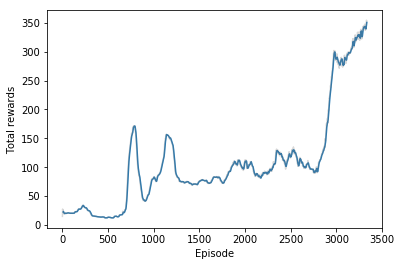

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

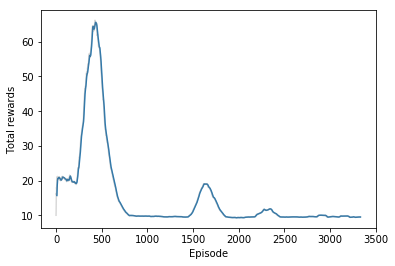

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

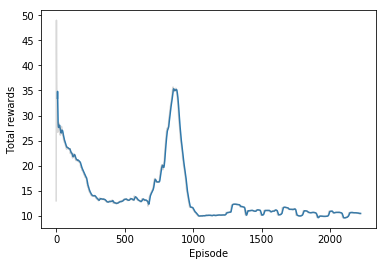

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

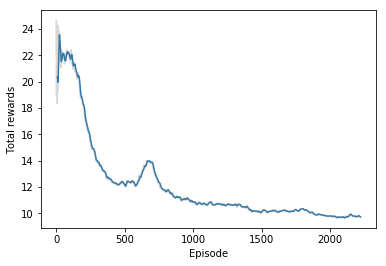

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

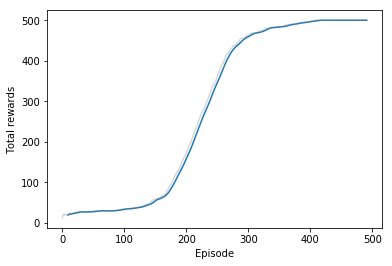

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

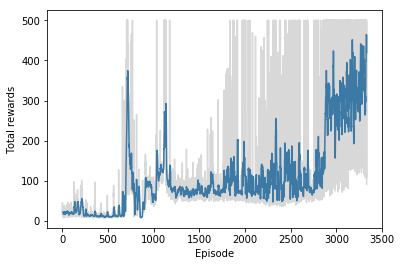

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

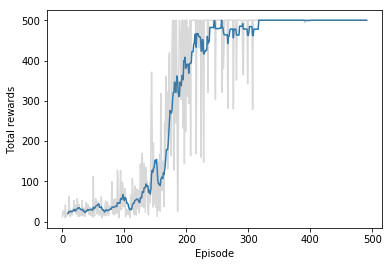

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.